Processing OwnDoc Dataset...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
OwnDoc - SoldTulips - RMSE: 58.81, sMAPE: 60.02, MAPE: 15259.76


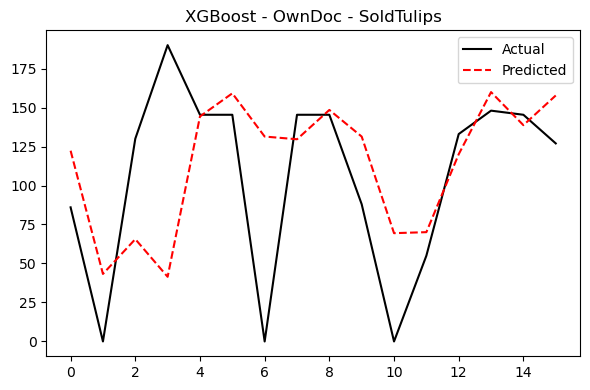


Processing CashierData Dataset...
Fitting 3 folds for each of 50 candidates, totalling 150 fits
CashierData - CutFlowers - RMSE: 61.67, sMAPE: 61.41, MAPE: 372.48


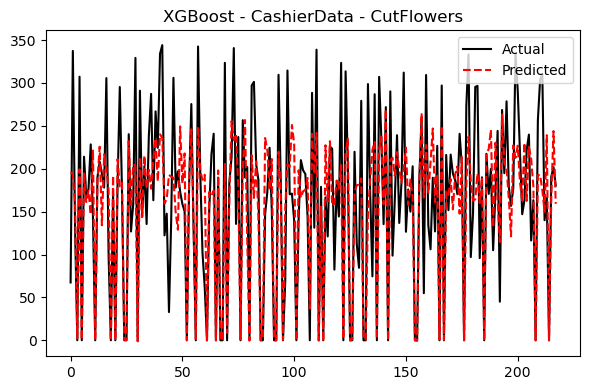

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Define helper functions for metrics
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def mape(y_true, y_pred):
    y_true = np.where(y_true == 0, 0.1, y_true)  # Avoid divide-by-zero errors
    return 100 * np.mean(np.abs((y_true - y_pred) / y_true))

# Load and preprocess datasets
def load_and_preprocess_data(file_path, target_col, percentile=80):  # Stricter outlier removal
    data = pd.read_csv(file_path)
    
    # Convert date/time columns to numerical values
    for col in data.columns:
        if 'date' in col.lower() or 'time' in col.lower():
            data[col] = pd.to_datetime(data[col]).map(pd.Timestamp.toordinal)

    # Label encoding for categorical columns
    label_encoders = {}
    for col in data.columns:
        if data[col].dtype == 'object':
            le = LabelEncoder()
            data[col] = le.fit_transform(data[col])
            label_encoders[col] = le

    # Remove outliers
    threshold = np.percentile(data[target_col], percentile)
    data = data[data[target_col] <= threshold]

    # Separate features and target
    X = data.drop(columns=[target_col])
    y = data[target_col]

    # Feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

# Train and evaluate XGBoost model
def train_evaluate_xgboost(X, y, target_name):
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Define hyperparameter grid
    param_grid = {
        'n_estimators': [1200, 1500],
        'learning_rate': [0.01, 0.05],
        'max_depth': [14, 16],
        'subsample': [0.8, 0.85],
        'colsample_bytree': [0.7, 0.75],
        'reg_alpha': [0.01, 0.05],
        'reg_lambda': [1.0, 1.2]
    }
    
    # Train model with RandomizedSearchCV
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    random_search = RandomizedSearchCV(
        xgb_model, param_distributions=param_grid, n_iter=50,
        scoring='neg_root_mean_squared_error', cv=3, verbose=1, random_state=42, n_jobs=-1
    )
    random_search.fit(X_train, y_train)
    
    # Best model
    best_model = random_search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    
    # Metrics
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    smape_value = smape(y_test, y_pred)
    mape_value = mape(y_test, y_pred)
    
    print(f"{target_name} - RMSE: {round(rmse, 2)}, sMAPE: {round(smape_value, 2)}, MAPE: {round(mape_value, 2)}")
    
    # Plot results
    plt.figure(figsize=(6, 4))
    plt.plot(y_test.values, label="Actual", color="black")
    plt.plot(y_pred, label="Predicted", linestyle="dashed", color="red")
    plt.title(f"XGBoost - {target_name}")
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return rmse, smape_value, mape_value

# Load, preprocess, and train for OwnDoc
print("Processing OwnDoc Dataset...")
X_owndoc, y_owndoc = load_and_preprocess_data('OwnDoc_preprocessed.csv', target_col='SoldTulips', percentile=80)
rmse_owndoc, smape_owndoc, mape_owndoc = train_evaluate_xgboost(X_owndoc, y_owndoc, "OwnDoc - SoldTulips")

# Load, preprocess, and train for CashierData
print("\nProcessing CashierData Dataset...")
X_cashier, y_cashier = load_and_preprocess_data('CashierData_preprocessed.csv', target_col='CutFlowers', percentile=80)
rmse_cashier, smape_cashier, mape_cashier = train_evaluate_xgboost(X_cashier, y_cashier, "CashierData - CutFlowers")

